In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

dftr=pd.read_csv('datasets/train.csv')
dftr.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
dftr.drop(['Name','Ticket', "Cabin", "PassengerId"],axis=1,inplace=True)


In [7]:
nan_rows = dftr[dftr.isna().any(axis=1)]
dftr['Embarked'].fillna("Q", inplace=True)
dftr['Sex'] = dftr['Sex'].replace({'female': 0, 'male': 1})
dftr['Embarked'] = dftr['Embarked'].replace({'S': 0, 'C': 1, "Q" : 2}).astype(int)
dftr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,0
3,1,1,0,35.0,1,0,53.1000,0
4,0,3,1,35.0,0,0,8.0500,0


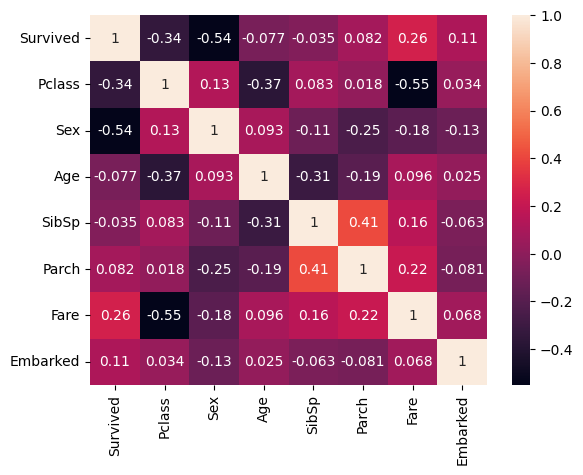

In [8]:
sn.heatmap(dftr.corr(), annot=True) # MADE A HEATMAP
plt.show()

In [9]:
print(dftr.dtypes)

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int32
dtype: object


In [10]:
# nan_rows = dftr[dftr['Age'].isna()]
# print(nan_rows)
mean_age = dftr['Age'].mean()
# print(mean_age)
dftr['Age'].fillna(30, inplace=True)
dftr['Age'] = dftr['Age'].astype(int)
dftr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,0,7.9250,0
3,1,1,0,35,1,0,53.1000,0
4,0,3,1,35,0,0,8.0500,0


In [11]:
# nan_rowsfare = dftr[dftr['Fare'].isna()]
# print(nan_rowsfare)

In [12]:
# mean_fare = dftr['Fare'].mean()
# print(mean_fare)
# dftr['Fare'].fillna(mean_fare, inplace=True)
# dftr.head()

In [13]:
# dftr.describe()

In [14]:
# dftr.hist(column='Age')
# dftr.hist(column='Pclass')
# dftr.hist(column='Embarked')

In [15]:
dftr['Survived'].corr(dftr['Age']) #Checks for correlation between survival and age
# As correlation is -7%, theres a negative but weakly negative correlation between survival and age. So as age goes down, survival does go up but not by much.  


-0.07064928577611441

In [16]:
dftr['Survived'].corr(dftr['Sex'])
# As correlation is -54%, theres a strong negative correlation between survival and gender. So as gender goes down (so becomes 0 meaning female), survival does go up by a lot.
# So males did have a lower chance of surviving.

-0.5433513806577547

In [17]:
dftr.corr() # I can see all correlations now
# Maybe do this before dropping columns next time

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.070649,-0.035322,0.081629,0.257307,0.114954
Pclass,-0.338481,1.000000,0.131900,-0.329822,0.083081,0.018443,-0.549500,0.034393
Sex,-0.543351,0.131900,1.000000,0.084241,-0.114631,-0.245489,-0.182333,-0.125265
Age,-0.070649,-0.329822,0.084241,1.000000,-0.232201,-0.180581,0.090782,0.020880
SibSp,-0.035322,0.083081,-0.114631,-0.232201,1.000000,0.414838,0.159651,-0.062871
Parch,0.081629,0.018443,-0.245489,-0.180581,0.414838,1.000000,0.216225,-0.081437
Fare,0.257307,-0.549500,-0.182333,0.090782,0.159651,0.216225,1.000000,0.068459
Embarked,0.114954,0.034393,-0.125265,0.020880,-0.062871,-0.081437,0.068459,1.000000


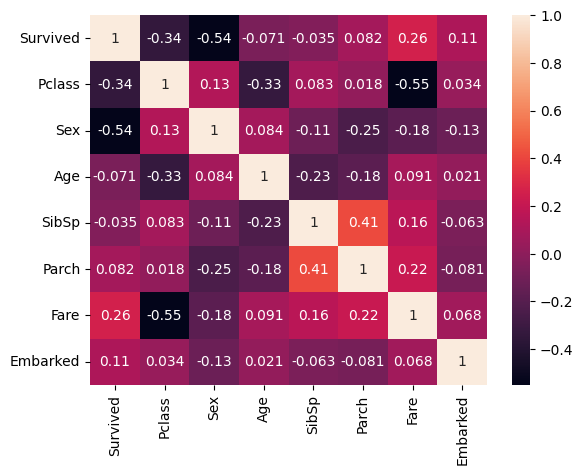

In [18]:
sn.heatmap(dftr.corr(), annot=True) # MADE A HEATMAP
plt.show()

In [19]:
children = dftr[dftr['Age'] < 18]
# children.hist()

In [20]:
living_children = dftr[(dftr['Age'] < 18) & (dftr['Survived'] == 1)]
dead_children = dftr[(dftr['Age'] < 18) & (dftr['Survived'] == 0)]

deadchildratio= dead_children.count()/(children.count())
print(deadchildratio) # 46% of kids died

Survived    0.460177
Pclass      0.460177
Sex         0.460177
Age         0.460177
SibSp       0.460177
Parch       0.460177
Fare        0.460177
Embarked    0.460177
dtype: float64


CLEANING THE TEST DATASET

In [21]:
dftst=pd.read_csv('datasets/test.csv')

# nan_rows1324 = dftst[dftst.isna().any(axis=1)]
# # print(nan_rows1324)

# nan_rows13 = dftst[dftst['Age'].isna()]

# dftst['Age'].fillna(30, inplace=True)
dftst.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
print(dftst.dtypes)

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [23]:
dftst.drop(['Name','Ticket',"Cabin"],axis=1,inplace=True)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [24]:
nan_rows = dftr[dftr.isna().any(axis=1)]
dftst['Embarked'].fillna("Q", inplace=True)
dftst['Sex'] = dftst['Sex'].replace({'female': 0, 'male': 1})
dftst['Embarked'] = dftst['Embarked'].replace({'S': 0, 'C': 1, "Q" : 2}).astype(int)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,2
1,893,3,0,47.0,1,0,7.0000,0
2,894,2,1,62.0,0,0,9.6875,2
3,895,3,1,27.0,0,0,8.6625,0
4,896,3,0,22.0,1,1,12.2875,0


In [25]:
dftst['Age'].fillna(30, inplace=True)
dftst['Age'] = dftst['Age'].astype(int)
dftst.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34,0,0,7.8292,2
1,893,3,0,47,1,0,7.0000,0
2,894,2,1,62,0,0,9.6875,2
3,895,3,1,27,0,0,8.6625,0
4,896,3,0,22,1,1,12.2875,0


In [26]:
nan_rowsfare = dftst[dftst['Fare'].isna()]
print(nan_rowsfare)

     PassengerId  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
152         1044       3    1   60      0      0   NaN         0


In [27]:
mean_faretest = dftst['Fare'].mean()
print(mean_faretest)
dftst['Fare'].fillna(mean_faretest, inplace=True)
dftst.head()

35.627188489208635


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34,0,0,7.8292,2
1,893,3,0,47,1,0,7.0000,0
2,894,2,1,62,0,0,9.6875,2
3,895,3,1,27,0,0,8.6625,0
4,896,3,0,22,1,1,12.2875,0


DOING THE ML

In [28]:
X_train = dftr.drop("Survived", axis=1)
Y_train = dftr["Survived"]
X_test  = dftst.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [29]:
# GOT 97.87% ACCURACY on this one

# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(X_train, Y_train)
# Y_pred = random_forest.predict(X_test)
# random_forest.score(X_train, Y_train)
# acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
# acc_random_forest
logr = LogisticRegression()
logr.fit(X_train, Y_train)
Y_pred = logr.predict(X_test)

# Used logistic regression and got a 1.2% better result in Kaggle

In [31]:
submission = pd.DataFrame({"PassengerId": dftst["PassengerId"],"Survived": Y_pred})
submission.to_csv('submission.csv', index=False) #Got 75% of the survivors right.